# Likelihood-free inference

## [Models in Population Biology](http://modelspopbiol.yoavram.com)
## Yoav Ram

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
sns.set_context('talk')

import warnings
warnings.simplefilter('ignore', FutureWarning)

red, blue, green, purple, orange = sns.color_palette('Set1', 5)
color_estimate = purple
color_truth = red

# Bayesian inference

*Reminder:* Bayesian inference is a method of statistical inference in which Bayes' theorem is used to update the probability for a hypothesis as more evidence or information becomes available. 

**Bayes' theorem**.
Consider the events $A$ and $B$, then Bayes' theorem states that

$$
P(A \mid B) = \frac{P(B \mid A) P(A)}{P(B)}
$$

Applied to model-based inference, we define:
- $\theta$ are the model parameters
- $X$ are the data
and we have
$$
P(\theta \mid X) = \frac{P(X \mid \theta) P(\theta)}{P(X)}
$$
where
- $P(\theta)$ is called the *prior probability* that formulates our beliefs about the model before seeing any data
- $P(X \mid \theta)$ is the probability of observing $X$ given $\theta$, what we called the *likelihood of $\theta$*
- $P(\theta \mid X)$ is called the *posterior probability*, that is, how our beliefs about the model changed due to observing the data
- $P(X)$ is the probability of observing the data unconditioned on the model; we usually ignore it as it does not depend on the model

In Bayesian inference we attempt to estimate the posterior distribution over the model parameters; this constrast with classical/frequentist approaches like *maximum likelihood* in which we attempt to estimate a point estimate of the parameters - a single parameter value.

**But what happens if we cannot write or even compute the likelihood function $P(X \mid \theta)$?**

The family of methods that try to resolve this problem are called **likelihood free inference** methods, and the most common one is approximate Bayesian computation, or ABC.

# Approximate Bayesian computation

ABC is a likelihood-free method of Bayesian inference that uses simulation to approximate the posterior distribution of the model parameters. 
It is used where
- the likelihood function is unknown or is too computationally expensive to compute, and
- there exists a good _forward model_ that can produce data sets like the one of interest.

It is not a replacement for other methods when a likelihood function is available (depsite the example we use in this lecture)!

In ABC, we cannot compute the likelihood $P(X \mid \theta)$.
But, we can sample from the distribution that this likelihood represents using a simulator, $X'=f(\theta)$.

We can then compare the simulated $X'$ and the observed $X$ to conclude if $\theta$ is likely -- thereby approximating the likelihood of $\theta$ without directly computing it.

![ABC](../resources/ABC.png)

Figure from [Cranmer et al, 2020](http://doi.org/10.1073/pnas.1912789117).

What do we need for ABC?

- we need a simulator $f(\theta)$ that samples from a distribution that approximates the likelihood function, that is $P(f(\theta)=X) = P(X \mid \theta)$.
- we need a good way (???) to summarize the data $S(X)$,
- we need a good way (???) to measure the distance between two summaries $\rho(S(X'), S(X))$, and
- we need a good way (???) to decide if the measured distance is small enough to accept the parameters that generated it.

# Over-dispersed Poisson model for count data

We use the compound gamma-Poisson model that we have seen before.

ere we assume that the measurements $\{X_i\}$ are still drawn from a Poisson distribution, but the expected values $\mu_i$ changes from leaf to leaf.
We assume it is drawn from a [Gamma distrubtion](https://en.wikipedia.org/wiki/Gamma_distribution#Related_distributions) with shape $r$ and scale $\phi$ ( with expected value $r\phi$ and variance $r\phi^2$):
$$
\mu_i \sim Gamma(r, \phi) \\
X_i \sim Poi(\mu_i)
$$

We note the model parameters as $\theta = (r, \phi)$.

In [2]:
# for reproducibility
np.random.seed(42)
n = 150
θ = (r, ϕ) = 5, 2

μi = np.random.gamma(r, scale=ϕ, size=n)
X = np.random.poisson(μi)

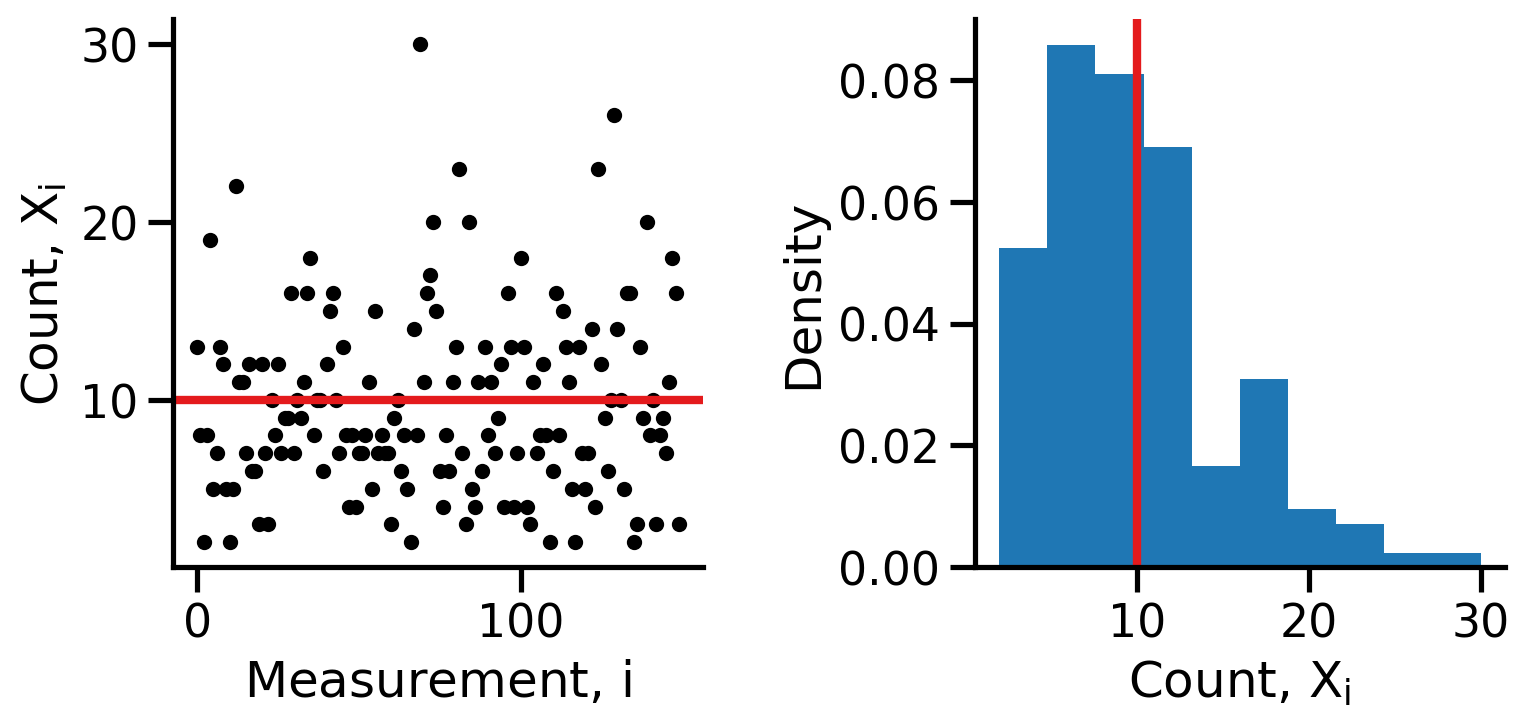

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax = axes[0]
ax.plot(np.arange(n), X, '.k')
ax.axhline(r*ϕ, linewidth=3, color=red)
ax.set_xlabel("Measurement, $i$")
ax.set_ylabel("Count, $X_i$")

ax = axes[1]
ax.hist(X, bins=10, density=True)
ax.axvline(r*ϕ, linewidth=3, alpha=1, color=red)
ax.set_ylabel("Density")
ax.set_xlabel("Count, $X_i$")

fig.tight_layout()
sns.despine()

## Rejection-ABC

Given empirical data $X$, a model parameterized by the vector $\theta$, and a simulator $f(\theta)$ that implements the model and generates simulated data $X'$, the following describes the *rejection sampling algorithm* for ABC:

1. Generate candidate parameter value from the prior $\theta^* \sim P(\theta)$  
1. Generate data from the simulation $X^* = f(\theta^*)$.
1. Calculate distance metric $\rho^* = \rho(S(X^*), S(X))$
1. Accept $\theta^*$ if $\rho^* \le \epsilon$.

The collection of accepted $\theta^*$ values approximates the posterior distribution $P(\theta \mid X)$; the smaller $\epsilon$ is, the better the approximation.

How do we set $\epsilon$?
In this case, we looked at the plot to get some intuition. 
If we don't have an intuition, we can take the best 1% or 5% of samples.
The problem is that the acceptance rate can be very low.
We'll deal with that in the next section.

We will use an uninformative prior just as we did before:
$$
r \sim \mathit{Uniform}(0, 10) \\
\phi \sim \mathit{Uniform}(0, 5)
$$

In [5]:
N = 100000

r_prior = scipy.stats.uniform(0, 10)
ϕ_prior = scipy.stats.uniform(0, 5)
rs = r_prior.rvs(size=N)
ϕs = ϕ_prior.rvs(size=N)

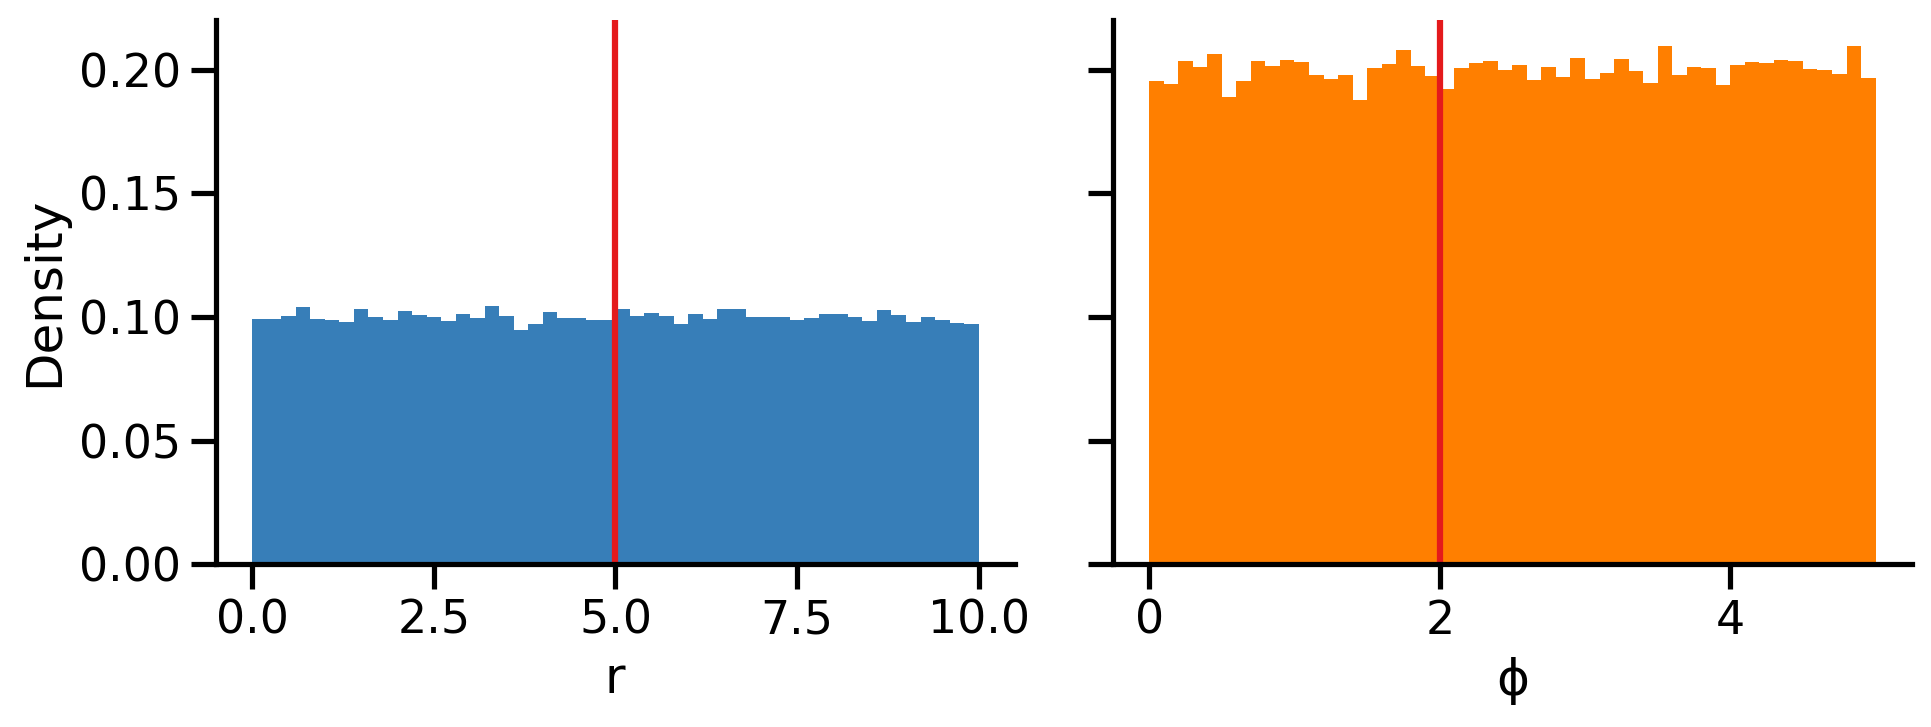

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].hist(rs, bins=50, color=blue, density=True)
axes[0].axvline(r, color=color_truth)
axes[1].hist(ϕs, bins=50, color=orange, density=True)
axes[1].axvline(ϕ, color=color_truth)
axes[0].set(xlabel='$r$', ylabel='Density')
axes[1].set(xlabel='$\phi$')
fig.tight_layout()
sns.despine()

We need a simulator, a summary, and a distance.

For summaries, we will use the mean and standard deviation.

$$
S_1(X) = \frac{1}{n}\sum_{i=1}^{n}{X_i} \\
S_2(X) = \sqrt{\frac{1}{n}\sum_{i=1}^{n}{(X_i - S_1(X))^2}} \\
$$

The distance function will be the absolute distance:
$$
\rho(X', X) = \big|S_1(X')-S_1(X)\big| + \big|S_2(X')-S_2(X)\big|
$$

Note that these functions expect a 2D array with shape `(experiments, samples)`; the idea is to use NumPy array operations to compute many simulations, summaries, and distances together.

In [55]:
def simulator(r, ϕ, nsamples=n):
    r, ϕ = np.atleast_1d(r, ϕ) # is scalar convert to 1d
    μ = scipy.stats.gamma(r, scale=ϕ).rvs(size=(nsamples, r.size)) # shape (nsamples, N)
    X_sim = scipy.stats.poisson(μ).rvs()
    return X_sim.T # shape (N, nsamples)

def summary(X):
    X = np.atleast_2d(X) # shape (N, nsamples)
    S1 = X.mean(axis=1) # over nsamples
    S2 = X.std(axis=1, ddof=1) # over nsamples
    return np.array([S1, S2]) # shape (2, N)

def distance(S_sim, S):
    diff = S - S_sim
    absdiff = np.abs(diff)
    return absdiff.sum(axis=0).squeeze() # sum over summaries, shape (N)

In [21]:
X_sim = simulator(rs, ϕs)
assert X_sim.shape == (N, n)
S = summary(X)
S_sim = summary(X_sim)
assert S_sim.shape == (2, N)
ρs = distance(S_sim, S)
assert ρs.shape == (N,)

We can take a look at what we got.

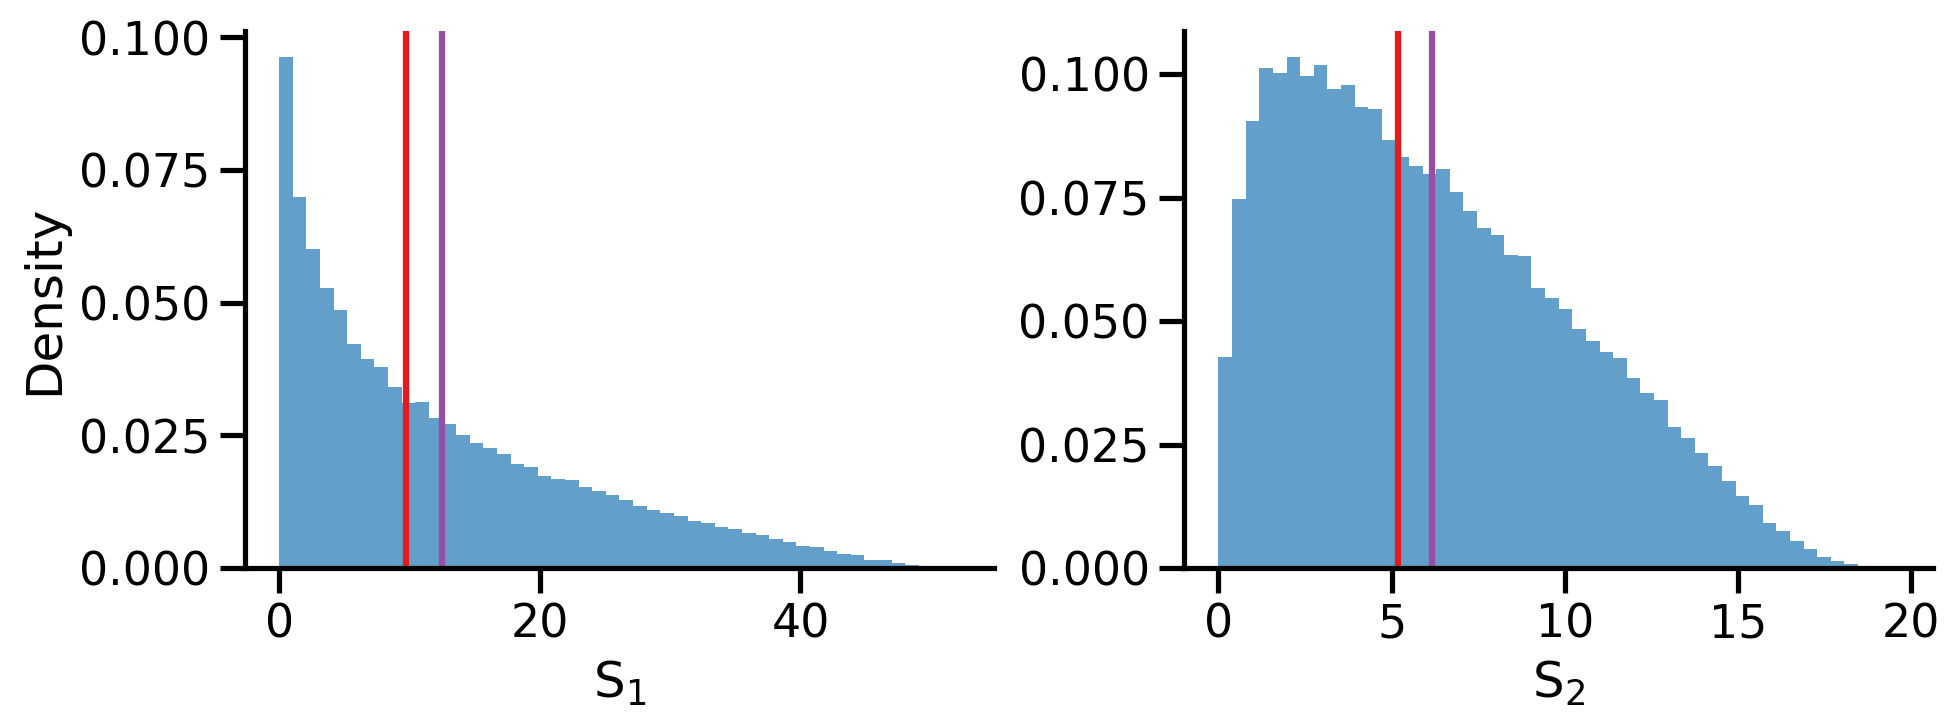

In [9]:
S1, S2 = S # S is shape (2,1)
S1_sim, S2_sim = S_sim # S_sim is shape (2,N)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
ax.hist(S1_sim, bins=50, alpha=0.7, density=True)
ax.axvline(S1, color=color_truth)
ax.axvline(S1_sim.mean(), color=color_estimate)
ax.set_xlabel(r"$S_1$")
ax.set_ylabel("Density")
ax = axes[1]
ax.hist(S2_sim, bins=50, alpha=0.7, density=True)
ax.axvline(S2, color=color_truth)
ax.axvline(S2_sim.mean(), color=color_estimate)
ax.set_xlabel(r"$S_2$")
fig.tight_layout()
sns.despine()

As for the distances, lets look at the standardized distance (distance divided by the standard deviation).

The plot shows the distance function for all the simulations (blue and green).
The red line shows the real parameter values.
The black line shows the value $\epsilon$, which is a threshold that accepts 10% of the samples.

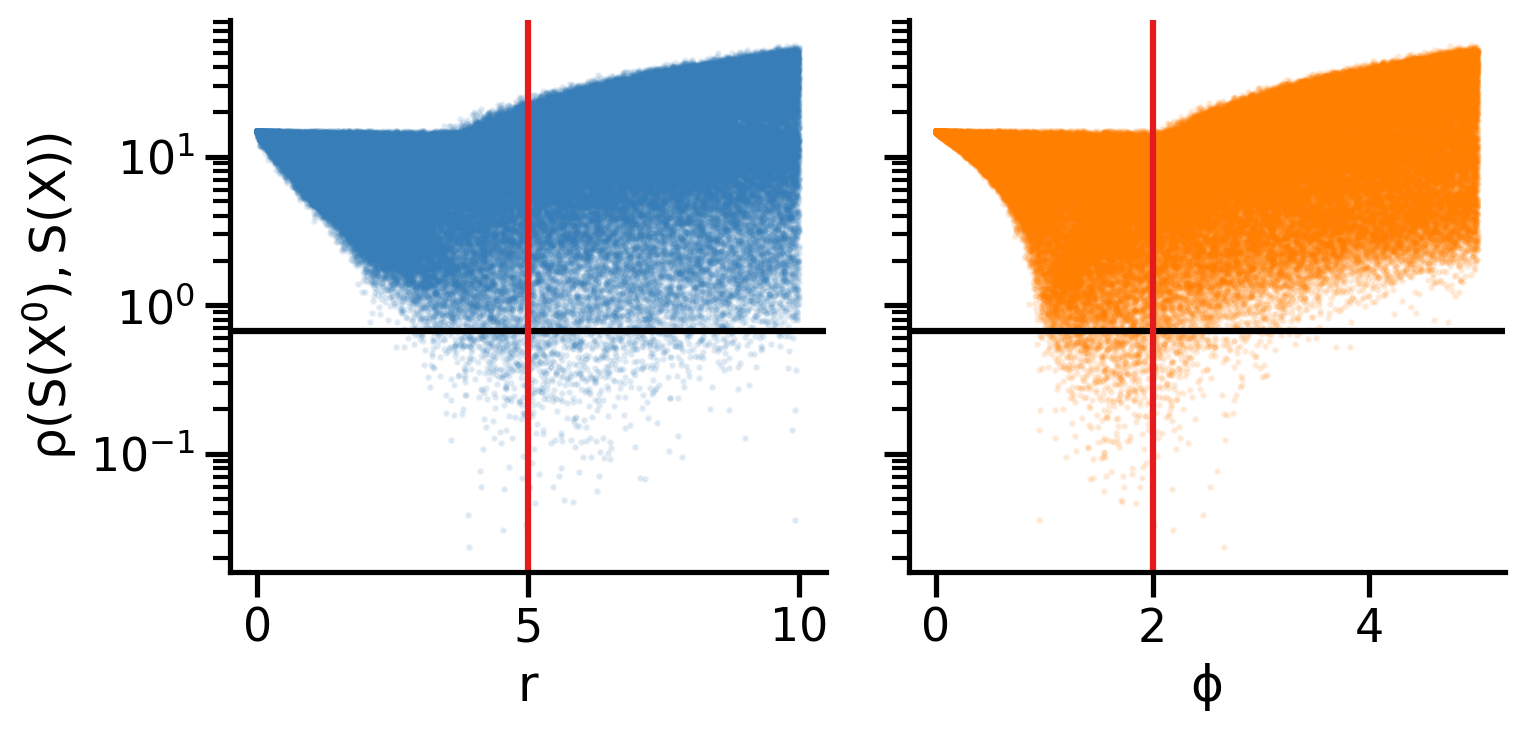

In [10]:
quantile = 0.01
ϵ = np.quantile(ρs, quantile)

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
plot_kws = dict(marker='.', ls='', markersize=3, alpha=0.1)
                  
ax = axes[0]
ax.plot(rs, ρs, color=blue, **plot_kws)
ax.axhline(ϵ, color='k')
ax.axvline(r, color=color_truth)
ax.set(xlabel='r', yscale='log', ylabel=r"$\rho(S(X'), S(X))$")

ax = axes[1]
ax.plot(ϕs, ρs, color=orange, **plot_kws)
ax.axhline(ϵ, color='k')
ax.axvline(ϕ, color=color_truth)
ax.set(xlabel='ϕ')

fig.tight_layout()
sns.despine()

We now accept and reject.

In [13]:
idx_accepted = ρs < ϵ
print("Accepted {} ({:.2%}) of {} generated samples with ϵ={:.4f}".format(
    idx_accepted.sum(), idx_accepted.mean(), idx_accepted.size, ϵ))
rs_accepted = rs[idx_accepted]
ϕs_accepted = ϕs[idx_accepted]

Accepted 1000 (1.00%) of 100000 generated samples with ϵ=0.6683


We now treat the accepted parameter samples as an approximate to the posterior distribtion and compute the point estimate.

For comparison, the MLE estimates were $\hat{r}_{mle} = 5.788$ and $\hat{\phi}_{mle} = 0.5955$ and the 
likelihood Bayesian inference estimates with PyMC were $\hat{r}_{PyMC} = 5.29$ and $\hat{\phi}_{PyMC} = 2.51$. So our results are pretty good.

In [15]:
r_hat, ϕ_hat = rs_accepted.mean(), ϕs_accepted.mean()

print("r = {} \tr_hat = {:.2f}\nϕ = {}\tϕ_hat = {:.2f}".format(
    r, r_hat, ϕ, ϕ_hat))

r = 5 	r_hat = 5.73
ϕ = 2	ϕ_hat = 1.81


We can plot the marginal and joint posterior distributions:

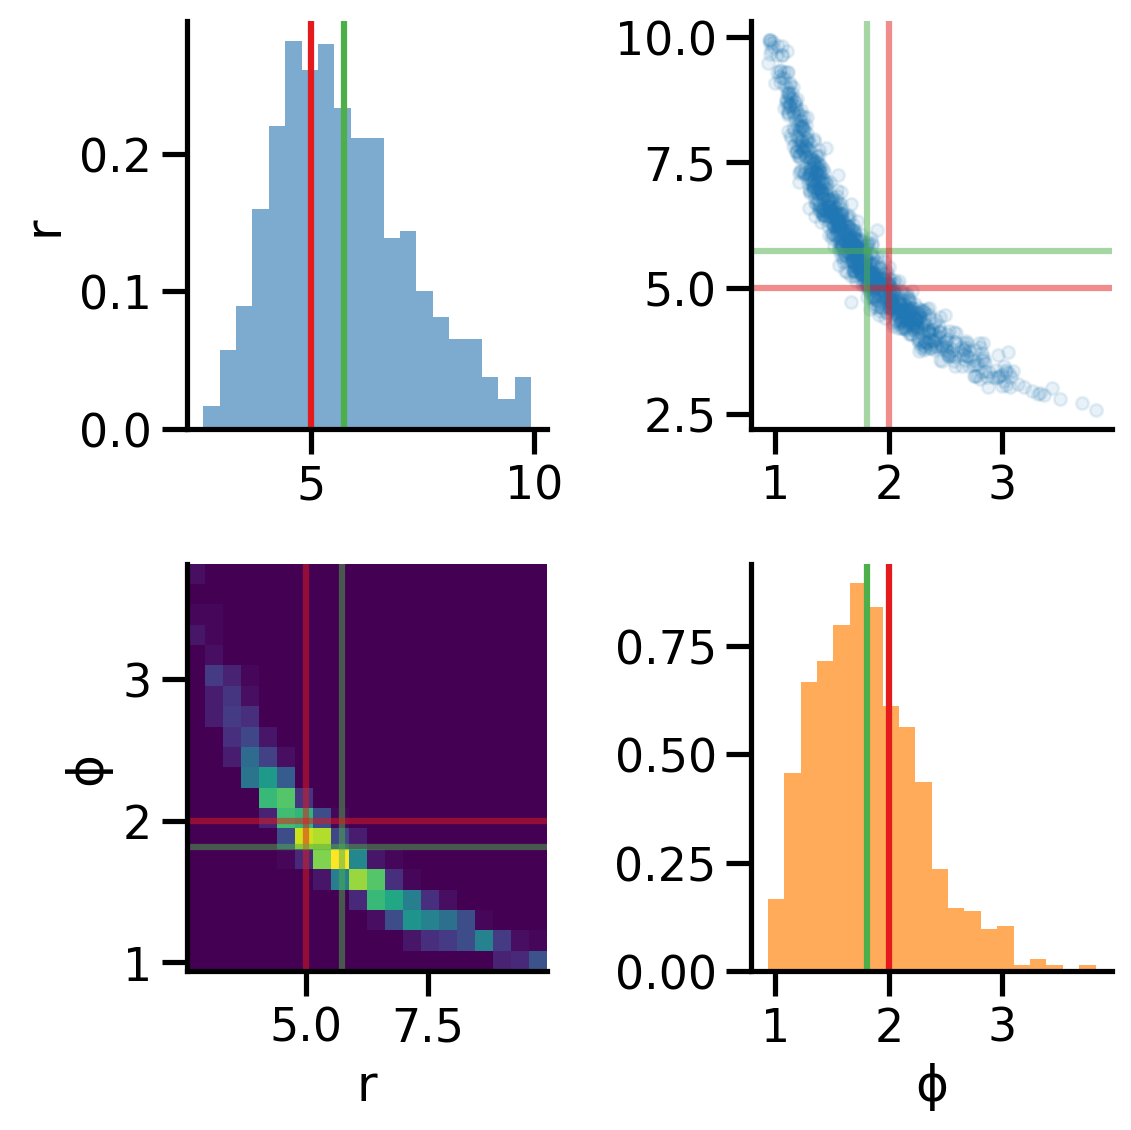

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
hist_kws = dict(bins=20, density=True, alpha=0.65)

ax = axes[0,0]
ax.hist(rs_accepted, color=blue, **hist_kws)
ax.axvline(r, color=red)
ax.axvline(rs_accepted.mean(), color=green)
ax.set(ylabel='r')

ax = axes[1,1]
ax.hist(ϕs_accepted, color=orange, **hist_kws)
ax.axvline(ϕ, color=red)
ax.axvline(ϕs_accepted.mean(), color=green)
ax.set(xlabel='ϕ')

ax = axes[0,1]
ax.plot(ϕs_accepted, rs_accepted, '.', alpha=0.1)
ax.axhline(r, color=red, alpha=0.5)
ax.axhline(rs_accepted.mean(), color=green, alpha=0.5)
ax.axvline(ϕ, color=red, alpha=0.5)
ax.axvline(ϕs_accepted.mean(), color=green, alpha=0.5)

ax = axes[1,0]
ax.hist2d(rs_accepted, ϕs_accepted, bins=20)
ax.set(xlabel='r', ylabel='ϕ')
ax.axvline(r, color=red, alpha=0.5)
ax.axvline(rs_accepted.mean(), color=green, alpha=0.5)
ax.axhline(ϕ, color=red, alpha=0.5)
ax.axhline(ϕs_accepted.mean(), color=green, alpha=0.5)


fig.tight_layout()
sns.despine()

The red and green lines are the true and estimated values of the parameters.

## MCMC-ABC

A common sampler that deals with the inefficiency of the rejection sampler is the Markov chain Monte Carlo (MCMC) sampler, which creates chains of accepted parameter samples of length $N$ using the algorithm:

1. Initiaize $\theta_1$, $i=1$.
1. Generate a candidate parameter value $\theta^* \sim q(\theta \mid \theta_i) = N(\theta_i, \eta)$.
1. Generate data from the simulator $X^* = f(\theta^*)$.
1. Calculate distance metric $\rho^* = \rho(S(X^*), S(X))$ using the summary $S(X)$.
1. If $\rho^* \le \epsilon$, set the acceptance probability $\alpha=\min{\Big(1, \frac{P(\theta^*)}{P(\theta_i)}\Big)}$. 
1. Otherwise set it to $\alpha=0$.
1. Accept $\theta_{i+1}=\theta^*$ with probability $\alpha$ and $\theta_{i+1}=\theta_i$ with probability $(1-\alpha)$.
1. If $i<N$, increment $i = i + 1$ and go to step 2.

This sampling algorithm is much more efficient than the rejection sampling, as it is able to "spend more time" in areas of high likelihood.

However, this algorithm can get stuck on areas of low likelihood.

In the simulation step, it is possible to simulate multiple simulations and summarize all of them. This will leverage NumPy array operations for increased efficiency and precision.

A nice example of using MCMC for ABC is presented in
> 1. Tanaka MM, Francis AR, Luciani F, Sisson SA. [Using approximate bayesian computation to estimate tuberculosis transmission parameters from genotype data](http://doi.org/10.1534/genetics.106.055574). Genetics. 2006;173(3):1511-1520. doi:10.1534/genetics.106.055574

## SMC-ABC

Sequential Monte Carlo sampler (SMC) is a more advanced Monte Carlo method that uses a different approach then MCMC.

Briefly, SMC creates a population of parameter samples ("particles"), and performs a series of steps similar to MCMC to move them around the parameter space. 
After a while it, it creates a new population from the samples that have distance less than $\epsilon$. It continues with the new population, and decreases $\epsilon$. 
The final population has a very low $\epsilon$, but the acceptance rate is higher than it would be in the rejection sampler with the same low $\epsilon$.
By using the particles that were accepted in the previous iteration to propose particles for the next iteration, we sample from an increasingly better approximation of the posterior, which allows to decrease epsilon while keeping good acceptance rates.

This sampler has several advantages -- an adaptive acceptance rate ($\epsilon$), independent sampling of parameters, computational efficiency, and more.
For details on the SMC sampler in ABC and a comparison to rejection and MCMC sampling, see:

> Sisson SA, Fan Y, Tanaka MM (2007) [Sequential Monte Carlo without likelihoods](http://doi.org/10.1073/pnas.0607208104). Proc Natl Acad Sci 104(6):1760–1765.

## ABC with PyMC

In [5]:
import pymc as pm
import arviz as az

print('PyMC', pm.__version__, 'Arviz', az.__version__)

PyMC 5.0.2 Arviz 0.15.1


In [6]:
def simulator(rng, r, ϕ, size=n):
    μ = rng.gamma(r, scale=ϕ, size=size)
    return rng.poisson(μ)

def summary(X):
    S1 = X.mean()
    S2 = X.std(ddof=1)
    return np.array([S1, S2])

In [8]:
gamma_poisson_model = pm.Model()
with gamma_poisson_model:
    r_ = pm.Uniform('r', lower=0, upper=10)
    ϕ_ = pm.Uniform('ϕ', lower=0, upper=5)
    
# standard PyMC:
#     μ_ = pm.Gamma('μ', alpha=r_, beta=1/ϕ_)
#     X_obs = pm.Poisson('X_obs', mu=μ_, observed=X)
#     idata_gamma_poisson = pm.sample(draws=10000)
    
# ABC PyMC; 'laplace' is equivalent to absolute difference
    X_obs = pm.Simulator('X_obs', simulator, params=(r_, ϕ_),
        distance='laplace', sum_stat=summary, observed=X)
    # progressbar gave me errors :(
    idata_gamma_poisson = pm.sample_smc(progressbar=False)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


/Users/yoavram/miniconda3/envs/modelspopbiol/lib/python3.10/site-packages/arviz/data/base.py:221: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


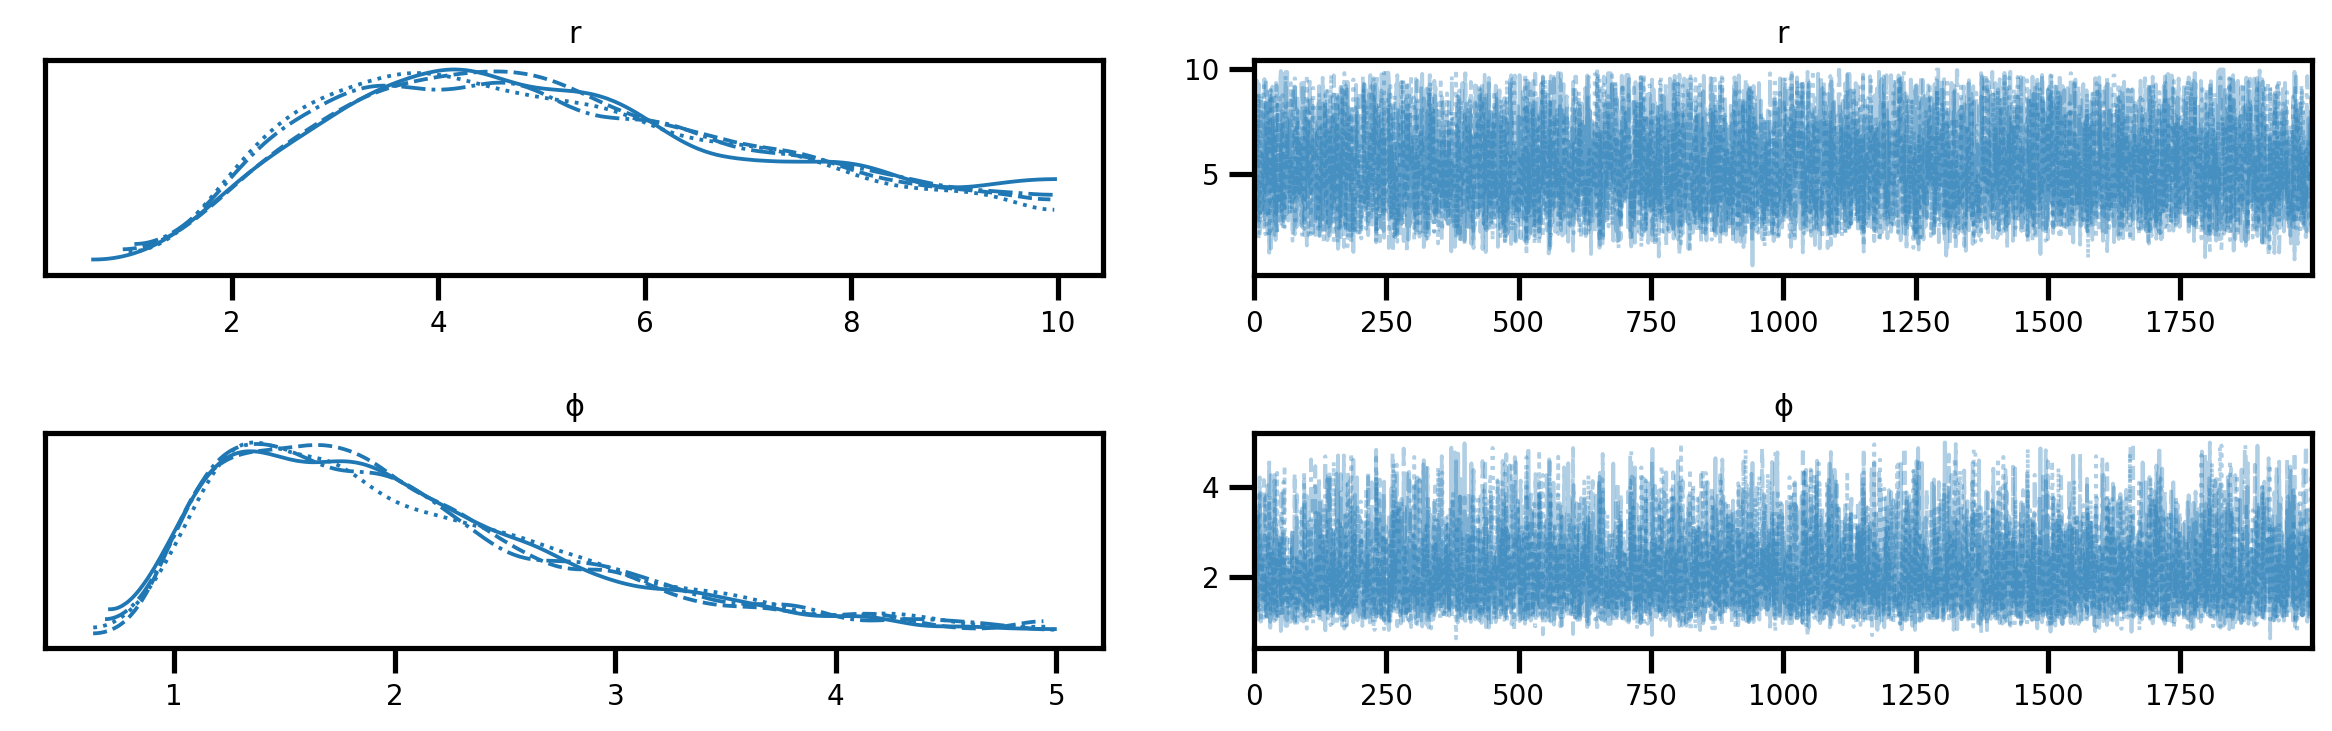

In [6]:
az.plot_trace(idata_gamma_poisson,)# combined=True)
plt.tight_layout()

In [7]:
print('r={}, ϕ={}'.format(r, ϕ))
az.summary(idata_gamma_poisson, round_to=2)

r=5, ϕ=2


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r,5.32,2.14,1.99,9.47,0.03,0.02,6095.52,4844.01,1.0
ϕ,2.11,0.88,0.83,3.83,0.01,0.01,6663.49,5218.16,1.0


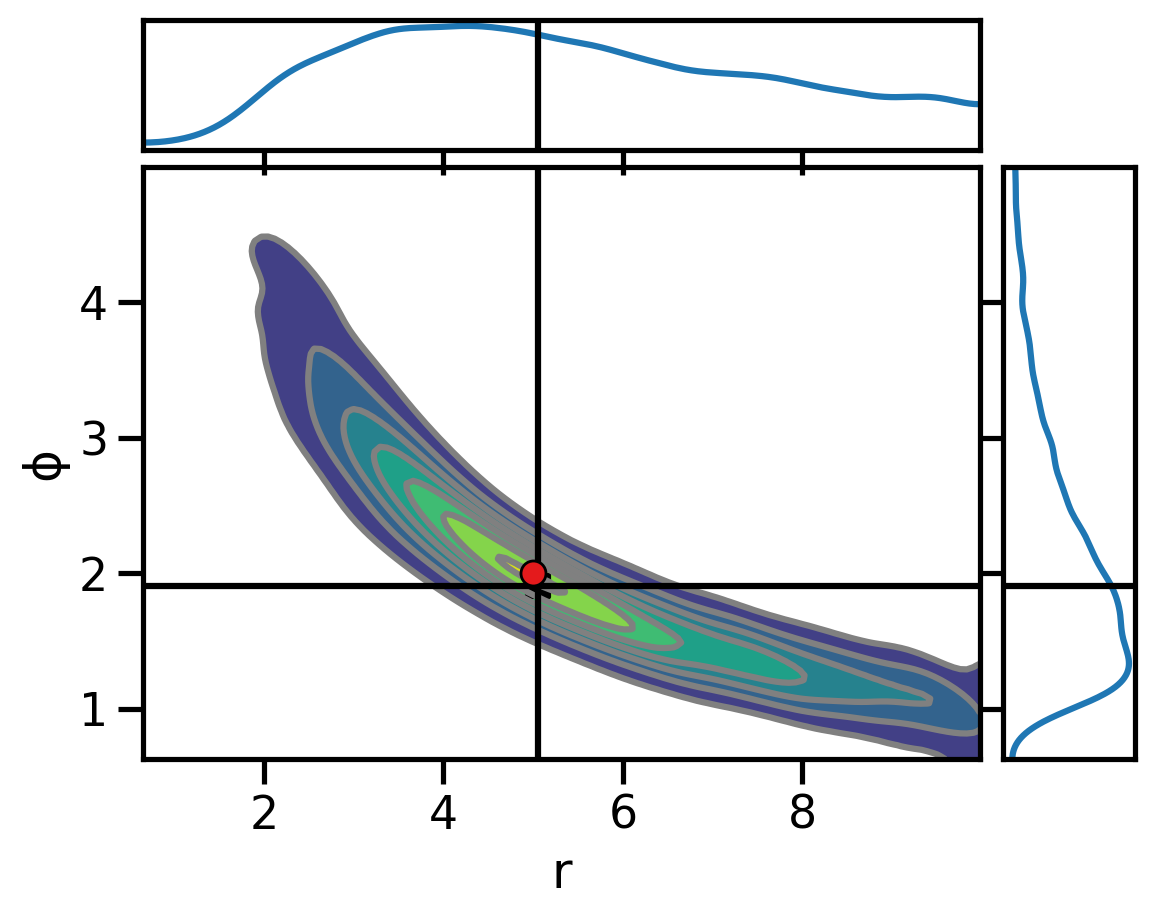

In [8]:
az.plot_pair(idata_gamma_poisson, 
    kind='kde', 
    marginals=True, 
    point_estimate='median',
    reference_values={'r':r, 'ϕ':ϕ},
    reference_values_kwargs=dict(color=red)
);

In [11]:
with gamma_poisson_model:
    idata_gamma_poisson.extend(pm.sample_posterior_predictive(idata_gamma_poisson))

Sampling: [X_obs]


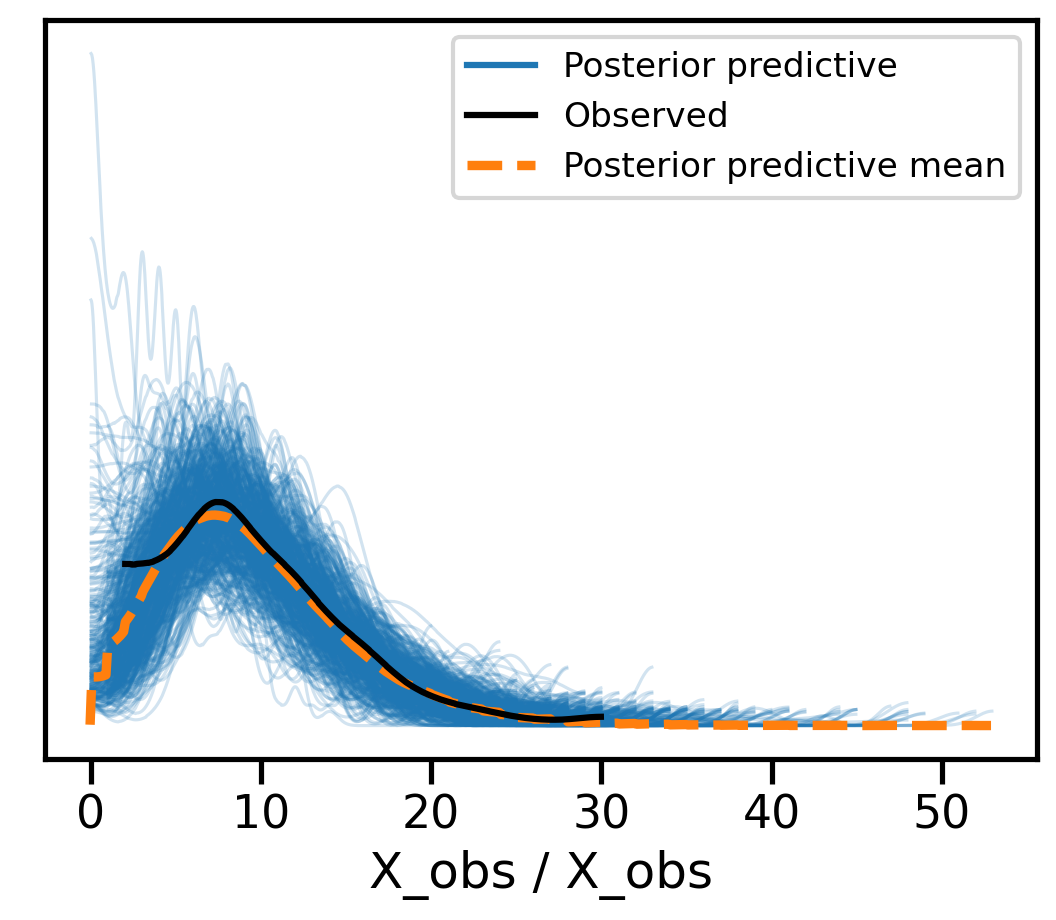

In [12]:
az.plot_ppc(idata_gamma_poisson, num_pp_samples=500);

# Dolphins social network model

We follow the analysis from a [paper on animal social networks](https://www.nature.com/articles/ncomms12084)
> Ilany A, Akçay E (2016) Social inheritance can explain the structure of animal social networks. Nat Commun 7(May). doi:10.1038/ncomms12084.

To work with graphs and networks we use [NetworkX](https://networkx.github.io), and we require at least version 2.

In [39]:
import networkx as nx
rng = np.random.default_rng()

In [14]:
def show_net(network):
    G = nx.from_numpy_array(network)
    nx.draw_spring(G, node_color='#4466ee', alpha=0.8)

We download the dolphins data from [KONECT](http://konect.cc/networks/dolphins/); this site has a bunch of network data.

Now load the data and convert it to NumPy adjacency matrix.

In [15]:
dolphin_data = np.loadtxt('../data/out.dolphins', comments='%', dtype=int)
dolphin_data[:5]

array([[ 9,  4],
       [10,  6],
       [10,  7],
       [11,  1],
       [11,  3]])

The adjacency matrix $A_{i,j}$ is 1 if dolphins $i$ and $j$ are "friends", and 0 otherwise.
"friends" are dolphins that interact in the same vicinity, or that have been observed together.

In [16]:
N = dolphin_data.max() # dolphin ids go from 1 to 62
dolphin_network = np.zeros((N, N), dtype=int)
for row in dolphin_data:
    src, dst = row
    # to zero count
    src -= 1
    dst -= 1
    # set connection
    dolphin_network[dst, src] = 1
    dolphin_network[src, dst] = 1

In [17]:
with open('dolphin_network.npy', 'wb') as f: 
    np.save(f, dolphin_network, allow_pickle=True)
dolphin_network

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

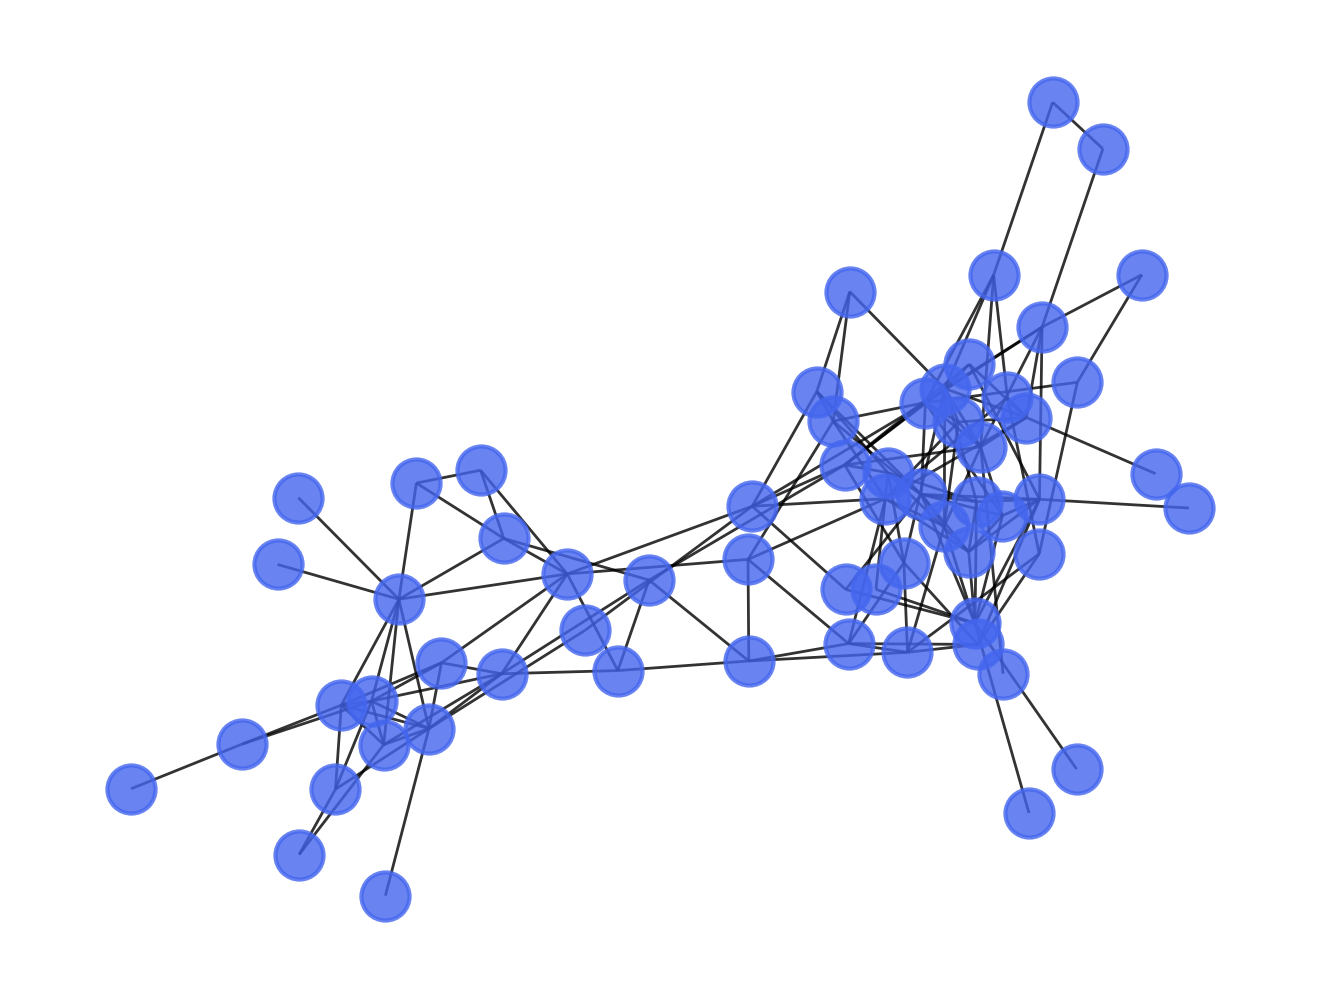

In [18]:
show_net(dolphin_network)

## Model and simulation

We model the development of a dolphin social network as in section _Simulation process_ of the paper by [Ilany and Akçay](https://www.nature.com/articles/ncomms12084).

For the initial networks, use the [Erdos-Renyi random network generator](https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.generators.random_graphs.erdos_renyi_graph.html); [read more on these random graphs](https://en.wikipedia.org/wiki/Erdős–Rényi_model).

In [59]:
def simulator(rng, pn, pr, size=(N,N)):
    assert size[0] == size[1], size
    tmax = 20 * N
    deaths = rng.integers(0, N, size=tmax)
    parents = rng.integers(0, N, size=tmax)
    randoms = rng.random(size=(tmax, N))

    G = nx.erdos_renyi_graph(size[0], p=0.1/2)
    network = nx.to_numpy_array(G, dtype=bool) # only in networkx 2
    
    for t in range(tmax):
        d = deaths[t]
        b = parents[t]
        network[d, :] = False
        network[:, d] = False
        moms_friends = network[b, :]
        rand = randoms[t, :]
        from_mom = moms_friends & (rand < pn)
        from_random = ~moms_friends & (rand < pr)
        network[d, :] = from_mom | from_random 
        network[d, b] = True
        network[:, d] = network[d, :]

    return network

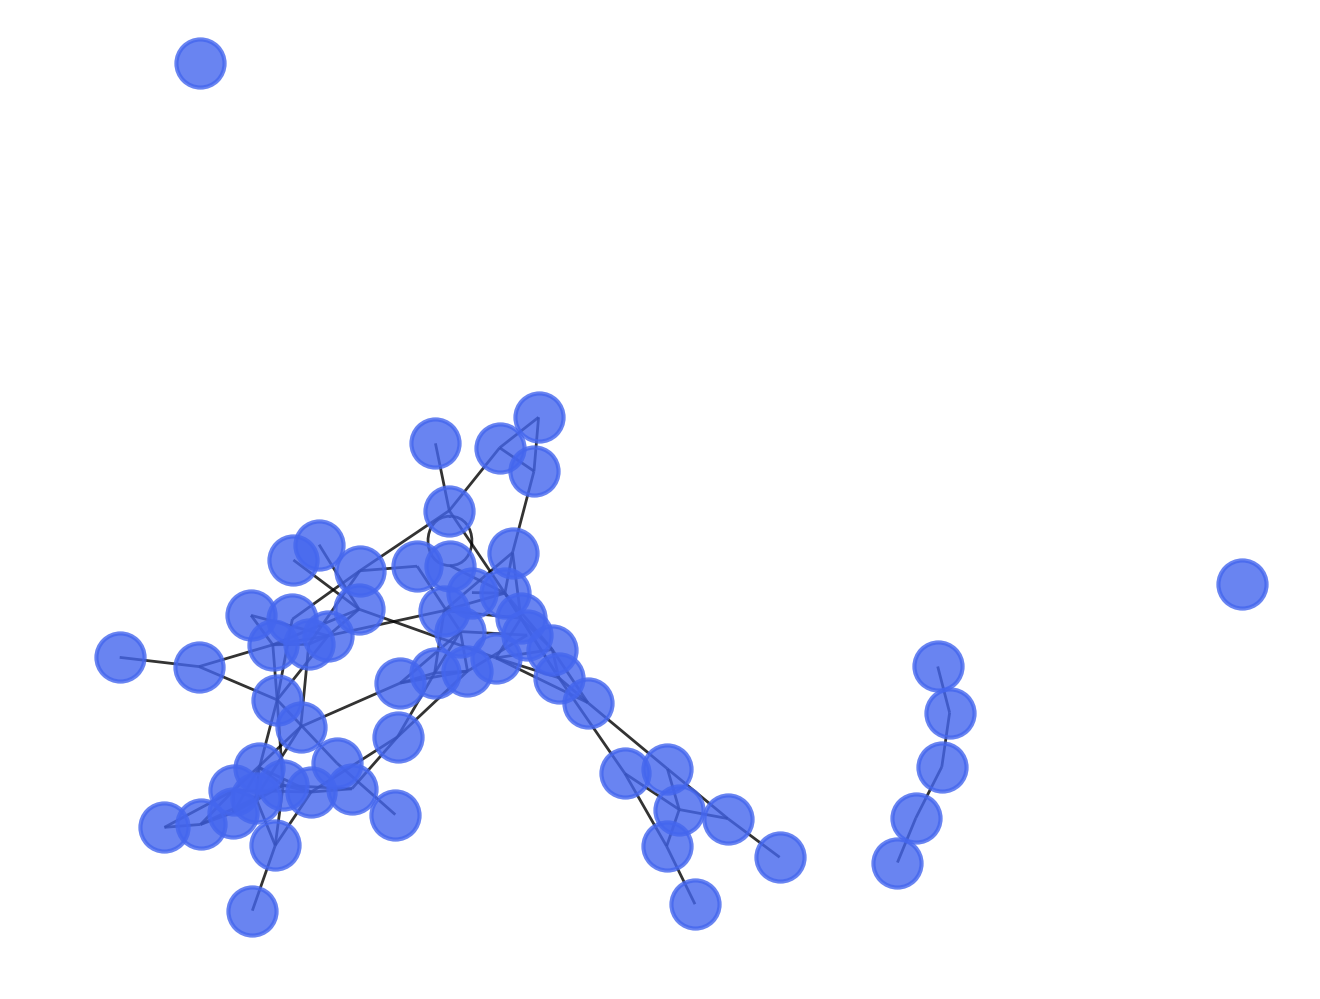

In [60]:
network = simulator(rng, 0.5, 0.01)
show_net(network)

## Summaries

We calculate the summary statistics, which are the mean degree of network nodes, and the clustering coefficient. 
- Degree of a node is the number of edges connected to it.
- Clustering coefficient of a node is the fraction of possible triangles through that node that exist, that is $\frac{2 T(u)}{deg(u)(deg(u)-1)}$, where $T(u)$ is the number of triangles passing through the node and $deg(u)$ is the node degree.

In [61]:
def mean_degree(network):
    degrees = network.sum(axis=0)
    return degrees.mean()

def clustering_coefficient(network):
    G = nx.from_numpy_array(network)
    clustering = nx.algorithms.clustering(G)
    return (np.fromiter(clustering.values(), dtype=float)).mean()

def summary(network):
    return np.array([mean_degree(network), clustering_coefficient(network)])

These are the summaries for the real network.

In [62]:
print("Mean degree {:.2f} \nClustering coefficient {:.2f}".format(
    mean_degree(dolphin_network),
    clustering_coefficient(dolphin_network)
))

Mean degree 5.13 
Clustering coefficient 0.26


In comparison, these are the summaries for a simulated network.

In [63]:
network = simulator(rng, 0.5, 0.01)
print("Mean degree {:.2f} \nClustering coefficient {:.2f}".format(
    mean_degree(network),
    clustering_coefficient(network)
)) 

Mean degree 2.90 
Clustering coefficient 0.35


## Inference with SMC

Now we'll use SMC-ABC to estimate the model parameters $p_n$ and $p_r$.
We set an uninformative prior $U(0,1)$ on both $p_n$ and $p_r$.
Otherwise we follow the same steps as above.

In [108]:
network_model = pm.Model()
with network_model:
    pn = pm.Uniform('pn', lower=0, upper=1)
    pr = pm.Uniform('pr', lower=0, upper=1)
    
    network = pm.Simulator('network', simulator, params=(pn, pr),
        distance='laplace', sum_stat=summary, observed=dolphin_network)
    # progressbar gave me errors :(
    idata_network = pm.sample_smc(kernel='ABC', draws=5000, progressbar=False) 

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


In [109]:
idata_network.to_netcdf("idata_dolphins_network.nc")

'idata_dolphins_network.nc'

In [110]:
idata_network = az.from_netcdf("idata_dolphins_network.nc")

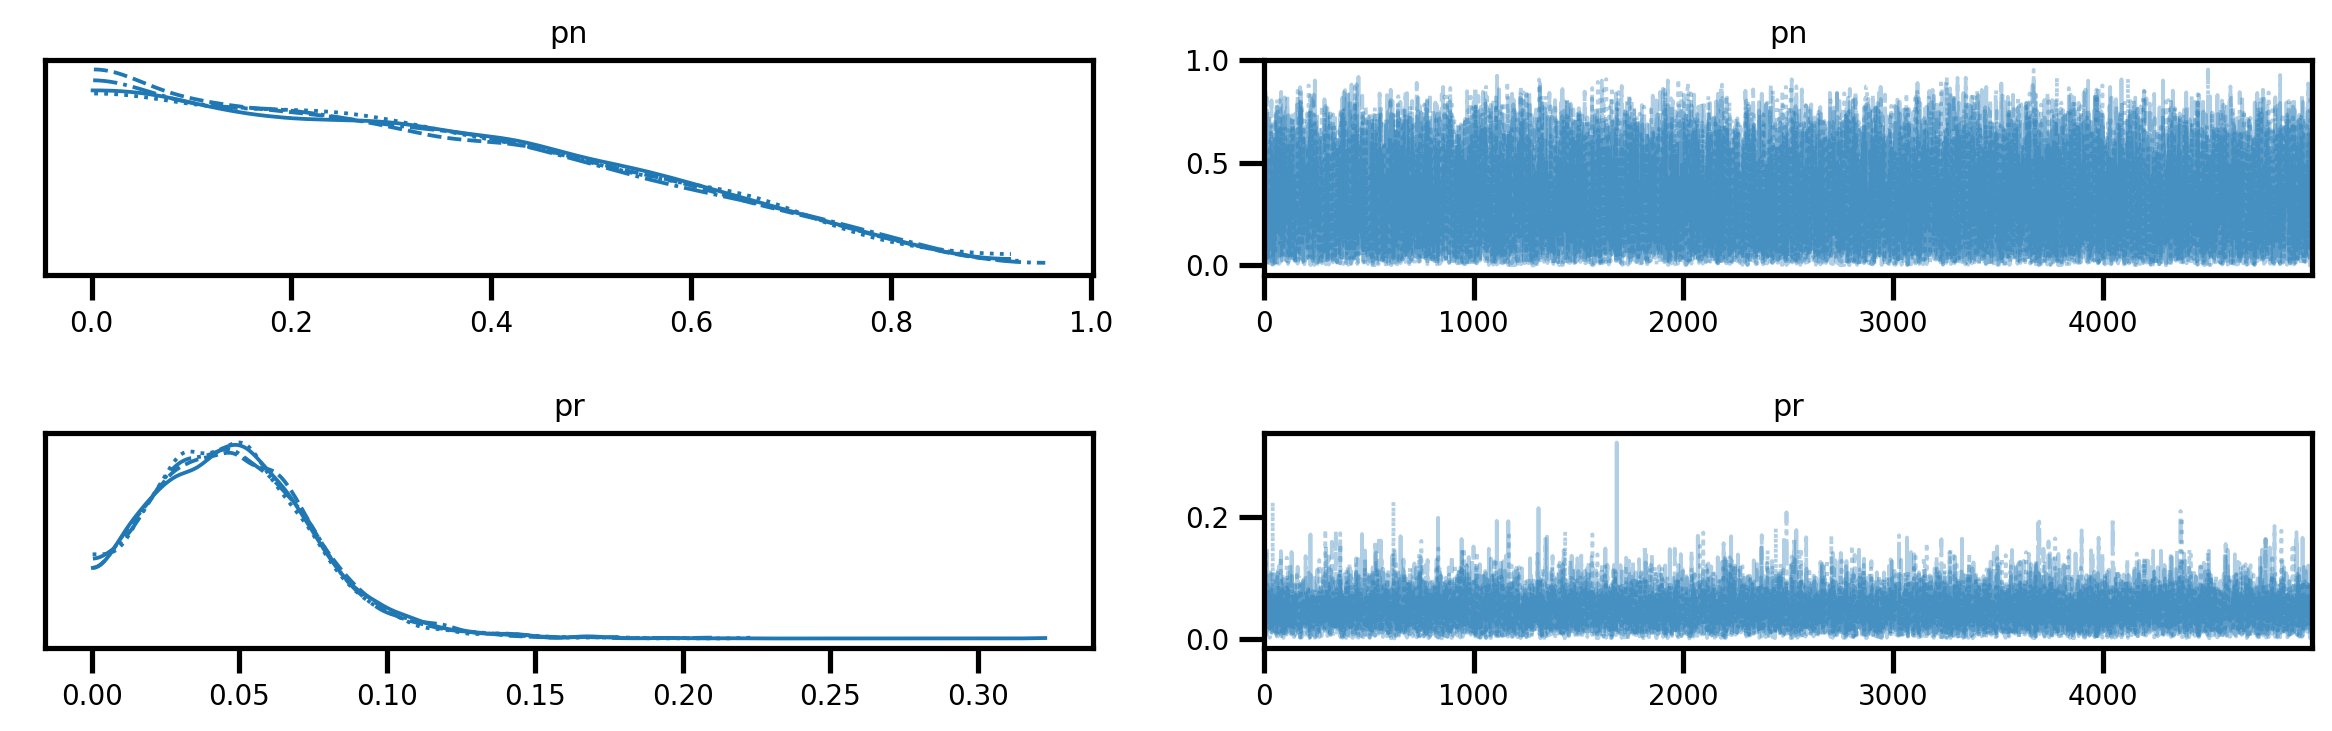

In [111]:
az.plot_trace(idata_network)
plt.tight_layout()

In [112]:
az.summary(idata_network, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pn,0.32,0.22,0.0,0.70,0.0,0.0,13835.32,8846.30,1.0
pr,0.05,0.03,0.0,0.09,0.0,0.0,16415.55,13705.09,1.0


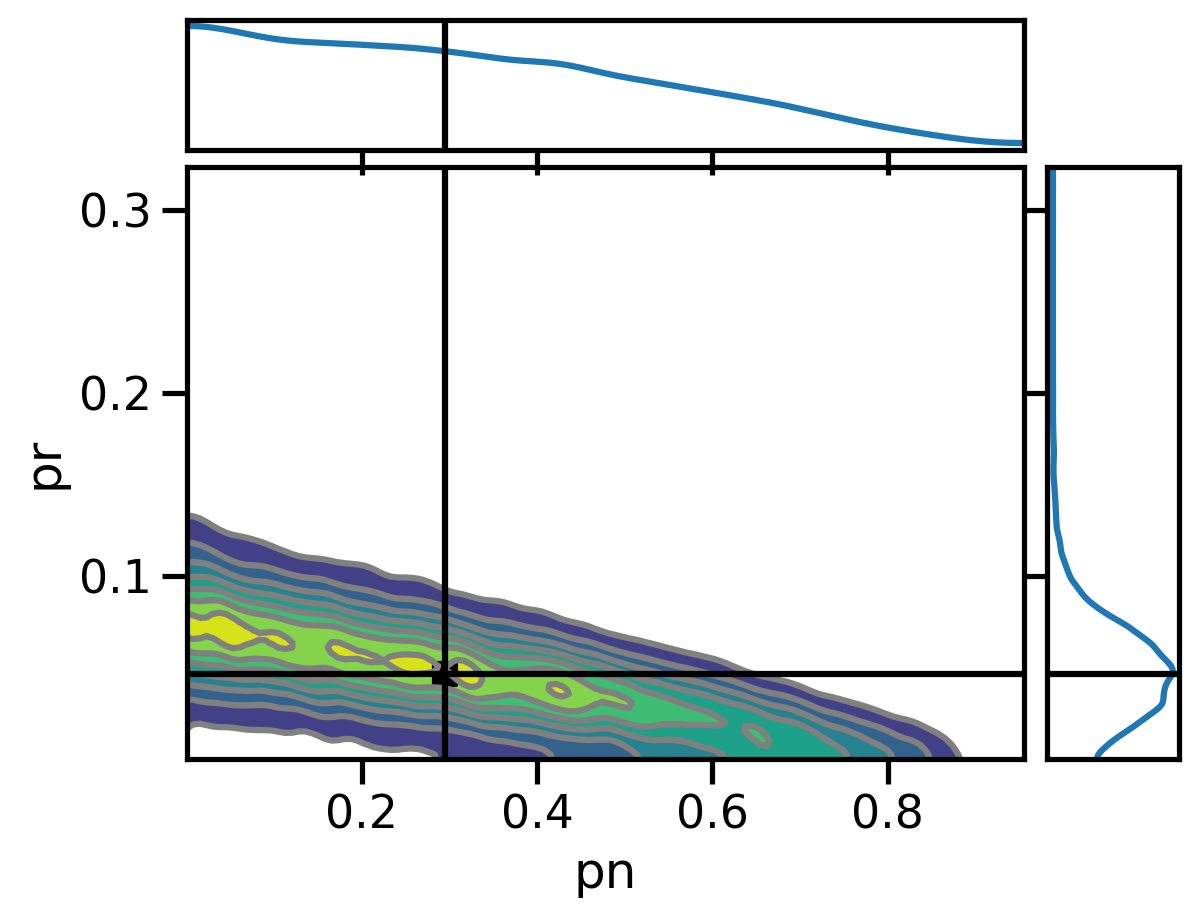

In [113]:
az.plot_pair(idata_network, 
    kind='kde', 
    marginals=True, 
    point_estimate='median',
);

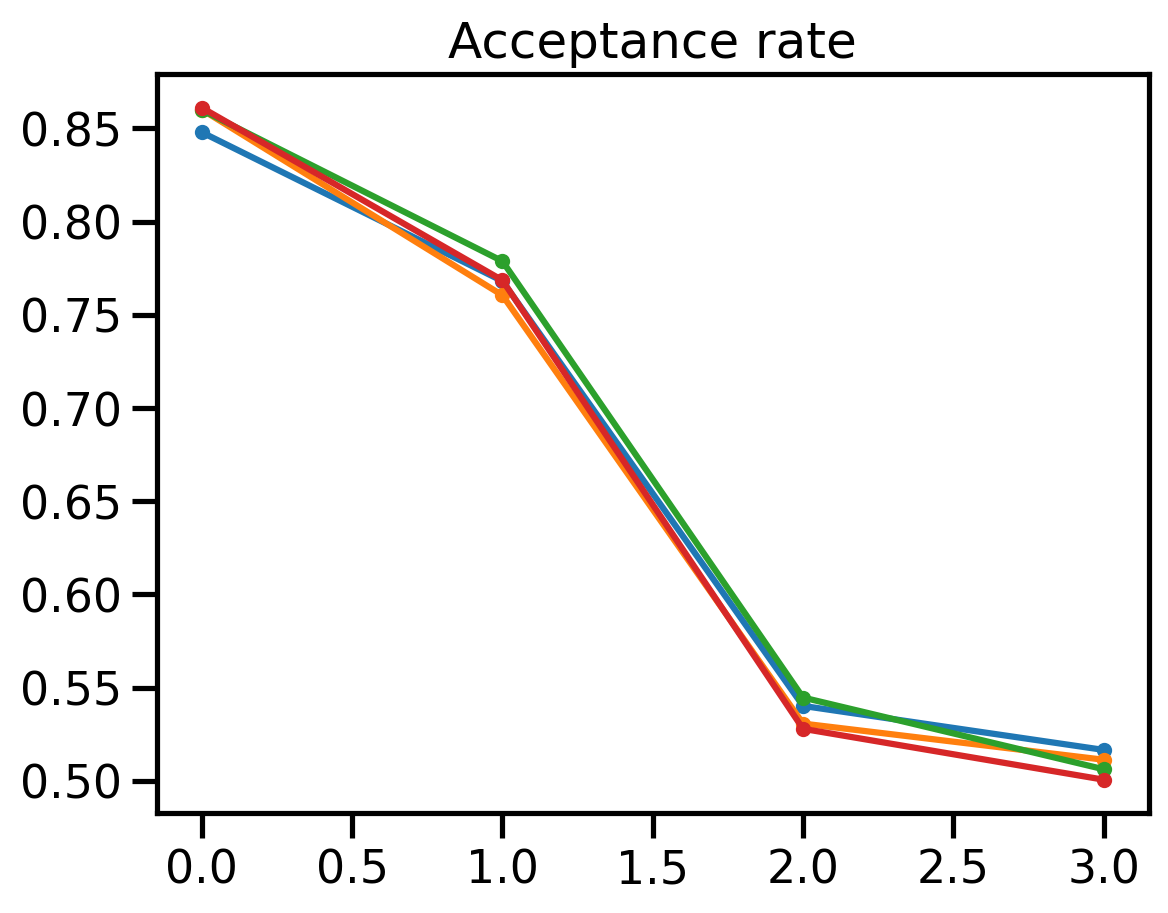

In [122]:
plt.plot(idata_network.sample_stats.accept_rate.T, '.-')
plt.title('Acceptance rate');

(0.0, 1.0)

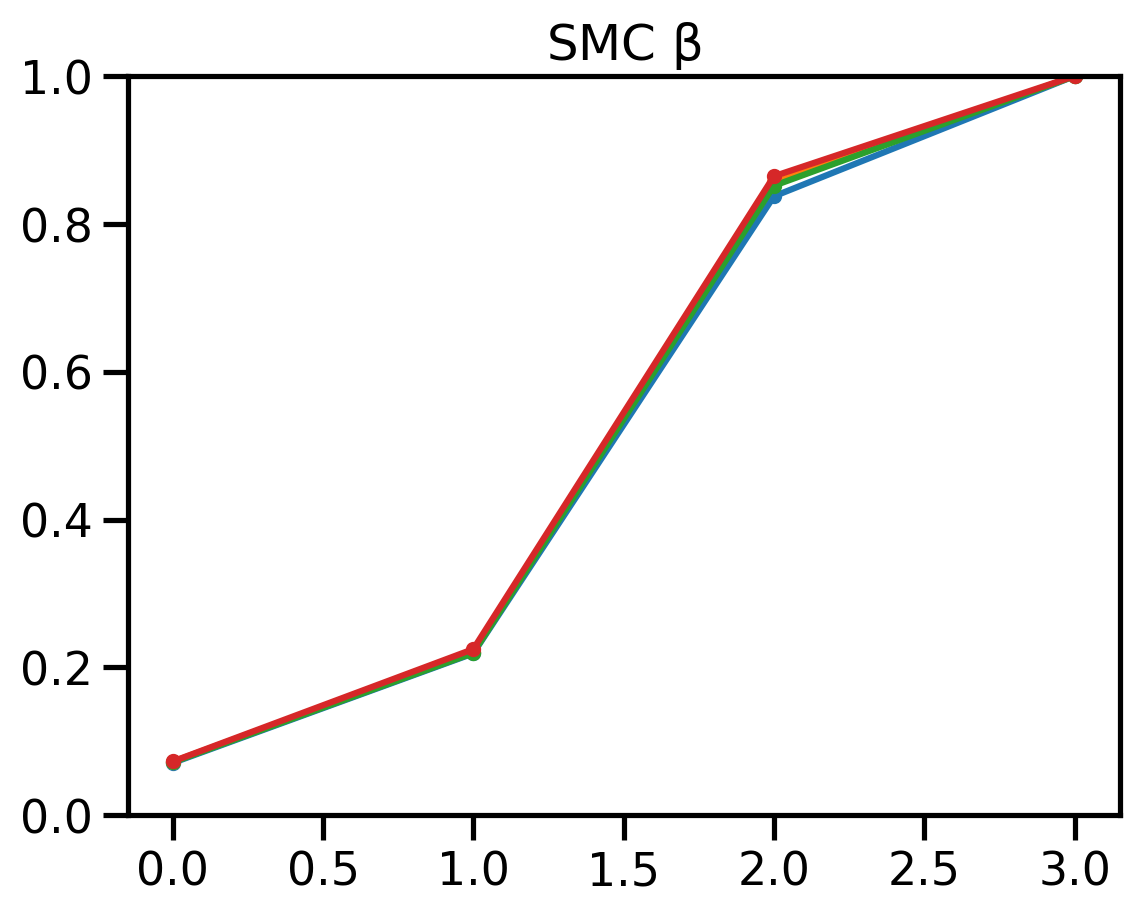

In [126]:
plt.plot(idata_network.sample_stats.beta.T, '.-')
plt.title(r'SMC $\beta$')
plt.ylim(0, 1)

## Posterior predictive check

We do a posterior prediction check to see if the posterior predictions for the summary statistics (blue histogram, point estimate in red) are inline with the observations (in black).

The summary statistics using the $p_n$ and $p_r$ estimated using PLS and analytical approximations by [Ilany and Akçay](https://www.nature.com/articles/ncomms12084) (see Table 1) are also drawn, in green.

In [114]:
posterior = idata_network.posterior.stack(samples=("draw", "chain"))
post_pn = np.array(posterior["pn"])
post_pr = np.array(posterior["pr"])
post_sum_stats = np.array([summary(simulator(rng, post_pn[i], post_pr[i])) for i in range(100)])

In [115]:
pymc_summary = post_sum_stats.mean(axis=0)
print('PyMC: {:.3f}, {:.3f}'.format(*pymc_summary))

networks = np.array([simulator(rng, 0.5, 0.028) for _ in range(100)])
pls_summary = np.mean([mean_degree(net) for net in networks]), np.mean([clustering_coefficient(net) for net in networks])
print('PLS: {:.3f}, {:.3f}'.format(*pls_summary))

networks = np.array([simulator(rng, 0.43, 0.036) for _ in range(100)])
analytic_summary = np.mean([mean_degree(net) for net in networks]), np.mean([clustering_coefficient(net) for net in networks])
print('Analytic: {:.3f}, {:.3f}'.format(*analytic_summary))

observed_summary = summary(dolphin_network)
print('Observed: {:.3f}, {:.3f}'.format(*observed_summary))

PyMC: 5.457, 0.214
PLS: 5.047, 0.289
Analytic: 5.115, 0.240
Observed: 5.129, 0.259


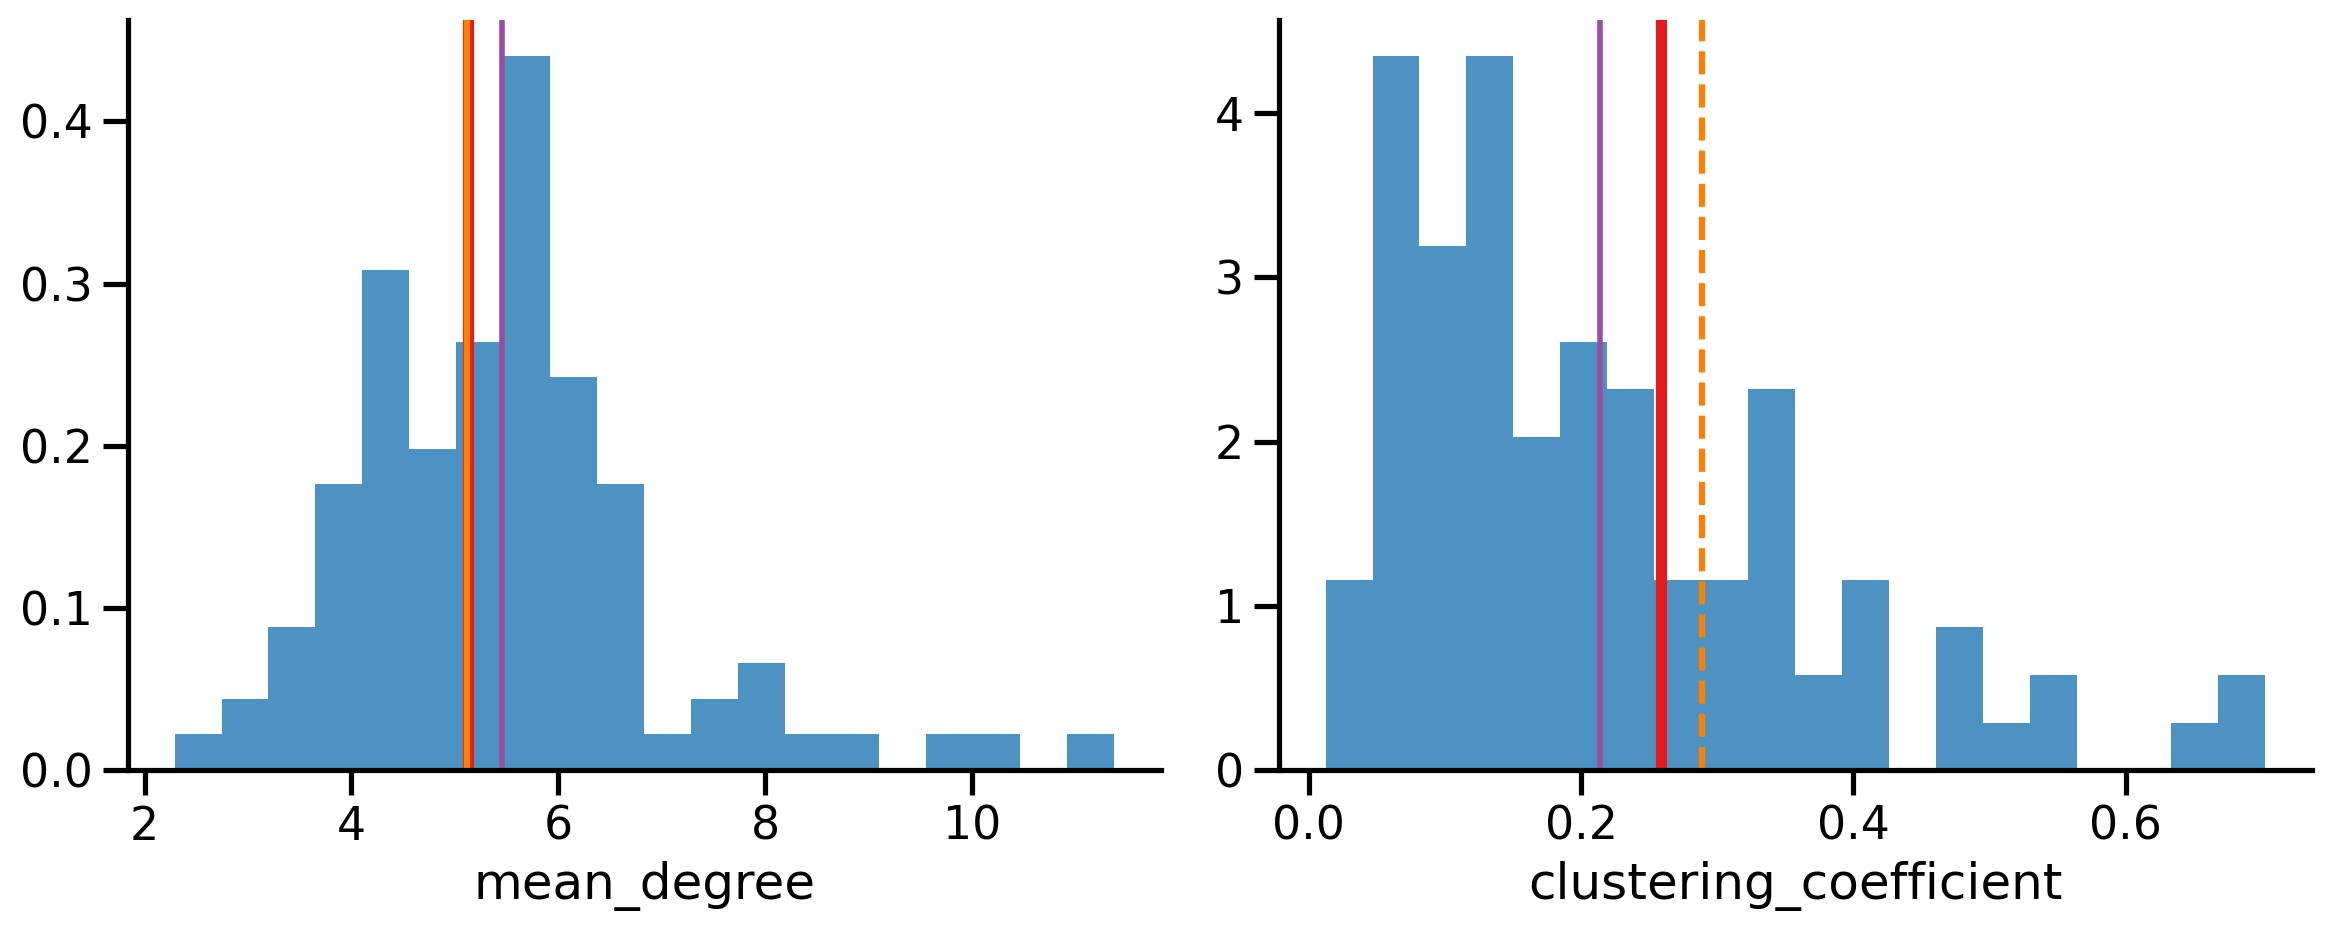

In [116]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(post_sum_stats[:,0], 20, density=True, alpha=0.8)
axes[0].axvline(observed_summary[0], lw=4, color=color_truth)
# axes[0].axvline(pls_summary[0], color=orange, ls='--') # too far
axes[0].axvline(analytic_summary[0], color=orange)
axes[0].axvline(pymc_summary[0], lw=2, color=color_estimate)
axes[0].set(xlabel='mean_degree')

axes[1].hist(post_sum_stats[:,1], 20, density=True, alpha=0.8)
axes[1].axvline(observed_summary[1], lw=4, color=color_truth)
axes[1].axvline(pls_summary[1], color=orange, ls='--')
axes[0].axvline(analytic_summary[0], color=orange)
axes[1].axvline(pymc_summary[1], lw=2, color=color_estimate)
axes[1].set(xlabel='clustering_coefficient')

fig.tight_layout()
sns.despine()

# References

- [Think Bayes, Bayesian Statistics Made Simple](http://greenteapress.com/wp/think-bayes/) by Allen B. Downey
- [Scott Linderman's notes on ABC](https://casmls.github.io/general/2016/10/02/abc.html)
- [Tanaka et al](http://doi.org/10.1534/genetics.106.055574)' paper on ABC-MCMC analysis of Tubercolosis in San Francisco
- [Sisson et al](http://doi.org/10.1073/pnas.0607208104)'s paper on ABC-SMC

# Colophon
This notebook was written by [Yoav Ram](http://www.yoavram.com) and is part of the [_Models in Population Biology_](https://modelpopbiol.yoavram.com/) course at Tel Aviv University.

This work is licensed under a CC BY-NC-SA 4.0 International License.